In [ ]:

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_capability())

In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp "/content/drive/My Drive/koulu_honmia/kandi19/IDA.zip" /content/

In [ ]:
!cp "/content/drive/My Drive/koulu_honmia/kandi19/benthic/loadbm.py" /content/

In [ ]:
%%capture
!unzip IDA.zip

In [ ]:
import numpy as np
import os
import ntpath
import platform
import matplotlib.pyplot as plt
from loadbm import create_df, create_tf_dataset, prepare_for_training


datapath = 'IDA/Separate lists with numbering/Machine learning splits'
img_path = 'IDA/Images/'

split = 1

train_fname = 'train'+str(split)+'.txt'
test_fname = 'test'+str(split)+'.txt'
val_fname = 'val'+str(split)+'.txt'

part_dat = False

df_train = create_df(os.path.join(datapath, train_fname),
                     img_path,
                     partial_dataset=part_dat,
                     seed=123)

df_test = create_df(os.path.join(datapath, test_fname),
                     img_path,
                     partial_dataset=part_dat,
                     seed=123)

df_val = create_df(os.path.join(datapath, val_fname),
                     img_path,
                     partial_dataset=part_dat,
                     seed=123)

from sklearn.utils import shuffle

df_train = shuffle(df_train)
df_val = shuffle(df_val)

df_train.head()

,path,label
60367,IDA/Images/Elmis_aen402/1-Elmis_aen402.1.2016-...,8
208399,IDA/Images/Micrasema_set275/0-Micrasema_set275...,24
153960,IDA/Images/Lepidostoma_hir221/1-Lepidostoma_hi...,18
303245,IDA/Images/Simuliidae733/1-Simuliidae733.1.201...,37
215818,IDA/Images/Nemoura_fle19/1-Nemoura_fle19.1.201...,26


Text(0.5, 1.0, 'pre-sampling')

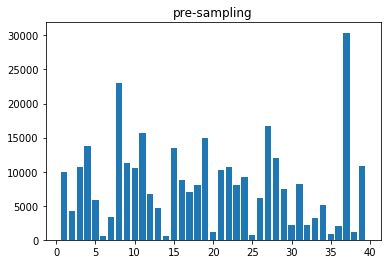

In [ ]:
h = np.histogram(df_train['label'],bins=39)[0]
plt.bar(range(1,40), h)
plt.title('pre-sampling')

In [ ]:
import pandas as pd
def calc_sampling(df, method='mean'):
    h = np.histogram(df['label'],bins=39)[0]
    if method=='mean':
      a = np.mean(h).astype(int)
    elif method=='max':
      a = np.max(h).astype(int)

    delta = a-h
    delta[delta <0] = 0

    return delta

delta = calc_sampling(df_train)


def oversample_df(df, delta):
    lst = [df]
    for i, group in df.groupby('label'):
        lst.append(group.sample(delta[i-1], replace=True))
        
    return pd.concat(lst)

Duplicate samples: 92018.
 Percentage: 0.222574832194473


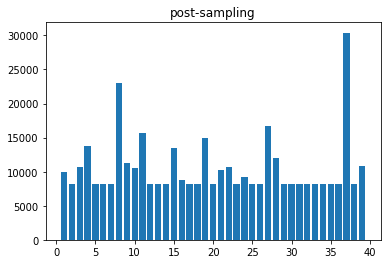

In [ ]:
df_train_new = oversample_df(df_train, 
                         calc_sampling(df_train, method='mean'))

h_new = np.histogram(df_train_new['label'],bins=39)[0]
plt.bar(range(1,40), h_new)
plt.title('post-sampling')
dup_amount = len(df_train_new)-len(df_train)
print('Duplicate samples: {}.\n Percentage: {}'.format(dup_amount,
                                                       dup_amount/len(df_train_new)))
df_train = df_train_new.copy()

In [ ]:
# Data augmentation
def train_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    #Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMSIZE = (224,224,3)
BATCH_SIZE = 32

train_ds = create_tf_dataset(df_train, imsize=IMSIZE, onehot=True)

val_ds = create_tf_dataset(df_val, imsize=IMSIZE, onehot=True)


train_ds = prepare_for_training(train_ds, 
                                shuffle_buffer_size=1000,
                                batch_size=BATCH_SIZE)

val_ds = prepare_for_training(val_ds, 
                              shuffle_buffer_size=1000,
                              batch_size=BATCH_SIZE)


# augmentation
train_ds.map(train_augment, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(5):
    print(image.shape)
    print(label.shape)


(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


def get_pretrained(imsize=(224, 224, 3), classes=39):
        base_model = InceptionV3(input_shape = imsize, 
                                 weights='imagenet', 
                                 include_top=False)
        
        base_model.trainable = True
        
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        predictions = Dense(classes, activation='softmax')(x)
        
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model

model = get_pretrained()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics=['accuracy'])


In [ ]:
import datetime

tr_steps = len(df_train)//BATCH_SIZE
val_steps = len(df_val)//BATCH_SIZE

model.fit(train_ds, 
          validation_data= val_ds, 
          steps_per_epoch= tr_steps, 
          epochs = 10,
          validation_steps = val_steps)


Train for 12919 steps, validate for 1434 steps
Epoch 1/10
12919/12919 [==============================] - 2080s 161ms/step - loss: 0.3843 - accuracy: 0.8814 - val_loss: 11.3775 - val_accuracy: 0.0073
Epoch 2/10
12919/12919 [==============================] - 2070s 160ms/step - loss: 0.3400 - accuracy: 0.8982 - val_loss: 21.1499 - val_accuracy: 0.0075
Epoch 3/10
12919/12919 [==============================] - 2069s 160ms/step - loss: 0.1352 - accuracy: 0.9612 - val_loss: 25.1783 - val_accuracy: 0.0115
Epoch 4/10
12919/12919 [==============================] - 2068s 160ms/step - loss: 0.0698 - accuracy: 0.9800 - val_loss: 28.1608 - val_accuracy: 0.0168
Epoch 5/10
12919/12919 [==============================] - 2067s 160ms/step - loss: 0.0472 - accuracy: 0.9868 - val_loss: 24.2039 - val_accuracy: 0.0174
Epoch 6/10
12919/12919 [==============================] - 2067s 160ms/step - loss: 0.0416 - accuracy: 0.9883 - val_loss: 37.0817 - val_accuracy: 0.0080
Epoch 7/10
12919/12919 [=================

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001) #original 0.001

from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    return 0.0001 * tf.math.exp(0.1 * (-epoch))

lr_cb = LearningRateScheduler(scheduler)

model.compile(optimizer = adam, loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

model.fit(train_ds, 
          validation_data= val_ds, 
          steps_per_epoch= tr_steps, 
          epochs = 5,
          validation_steps = val_steps,
          callbacks=[lr_cb])

NameError: ignored

In [ ]:
model.save('24-02-2020_cont_colab.h5')

In [ ]:
!cp '24-02-2020_cont_colab.h5' "/content/drive/My Drive/koulu_honmia/kandi19/"

Evaluation:

In [ ]:
test_ds = create_tf_dataset(df_test, imsize=IMSIZE, onehot=True)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
!cp "/content/drive/My Drive/koulu_honmia/kandi19/benthic/combine_insects.py" /content/

In [ ]:
preds = model.predict(test_ds, verbose=True)
yhat = np.argmax(preds,axis=1)+1
y_test = df_test['label']

acc = np.sum(yhat==y_test)/len(y_test)
print('Image accuracy: {:.4f}'.format(acc))

In [ ]:
#%% Insect combine
from combine_insects import add_insect_class, add_yhat

df_test_preds = add_insect_class(df_test)

# adding predictions to dataframe for insect-wise prediction
df_test_preds = add_yhat(df_test_preds,yhat)

dfg = df_test_preds.groupby(['label','insect'],as_index=False)['pred'].agg(lambda x:x.value_counts().index[0])

acc_g = np.sum(dfg['pred']==dfg['label'])/len(dfg)
print('Aggregate accuracy: {:.4f}'.format(acc_g))

In [ ]:
np.save('24-02-2020_cont_colab.npy', preds)

In [ ]:
!cp '24-02-2020_cont_colab.npy' "/content/drive/My Drive/koulu_honmia/kandi19/"